In [1]:
!git clone https://github.com/karencfisher/landmark-classifier.git
%cd landmark-classifier

fatal: destination path 'landmark-classifier' already exists and is not an empty directory.
/content/landmark-classifier


In [2]:
import torch
import torch.nn as nn
import sqlite3
import json

from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.train import one_epoch_test
from src.helpers import setup_env

In [3]:
# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [4]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 5        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.002  # Learning rate for SGD (or Adam)
momentum = 0.9         # momentum for SGD
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4     # regularization. Increase this to combat overfitting


In [5]:
%%writefile models/model1.py
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4,4))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


Overwriting models/model1.py


In [6]:
%run models/model1.py
model = MyModel(num_classes)
model

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [8]:
from overfit_one_batch import one_batch_train

data_loaders = get_data_loaders(batch_size, valid_size)
one_batch_train(model, data_loaders['train'], 'cuda')

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
step 000 | loss 3.8969 | acc 0.000
step 020 | loss 2.2684 | acc 0.531
step 040 | loss 0.9116 | acc 0.844
step 060 | loss 0.1506 | acc 1.000
step 080 | loss 0.0620 | acc 1.000
step 100 | loss 0.0358 | acc 1.000
step 120 | loss 0.0242 | acc 1.000
step 140 | loss 0.0179 | acc 1.000
step 160 | loss 0.0140 | acc 1.000
step 180 | loss 0.0114 | acc 1.000


In [7]:
from basic_training import train

data_loaders = get_data_loaders(batch_size, valid_size)
optimizer = get_optimizer(model, opt, learning_rate, weight_decay=weight_decay,
                          momentum=momentum)
loss = get_loss()
train(model, 'cuda', optimizer, data_loaders['train'], loss)

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


epoch 1/5: 100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch 1/5 — Loss: 3.9039, Acc: 0.0238


epoch 2/5: 100%|██████████| 125/125 [00:40<00:00,  3.06it/s]


Epoch 2/5 — Loss: 3.8432, Acc: 0.0485


epoch 3/5: 100%|██████████| 125/125 [00:40<00:00,  3.07it/s]


Epoch 3/5 — Loss: 3.7391, Acc: 0.0808


epoch 4/5: 100%|██████████| 125/125 [00:40<00:00,  3.08it/s]


Epoch 4/5 — Loss: 3.6034, Acc: 0.1019


epoch 5/5: 100%|██████████| 125/125 [00:40<00:00,  3.07it/s]

Epoch 5/5 — Loss: 3.5247, Acc: 0.1174


In [9]:
# Train
# Set random seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

import random
random.seed(seed)
import numpy as np
np.random.seed(seed)


data_loaders = get_data_loaders(batch_size, valid_size)
optimizer = get_optimizer(model, opt, learning_rate, weight_decay=weight_decay,
                          momentum=momentum)
loss = get_loss()

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, mode='min',
                                                #    factor=0.1, pateince=3)
scheduler = None

model = MyModel(num_classes)

train_losses, valid_losses = optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    scheduler=scheduler
)


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.41it/s]


Epoch: 1 	Training Loss: 3.915152 	Validation Loss: 3.917600
New minimum validation loss: 3.917600. Saving model ...



Validating: 100%|███████████████████████████████| 32/32 [00:08<00:00,  3.57it/s]


Epoch: 2 	Training Loss: 3.915199 	Validation Loss: 3.919583



Validating: 100%|███████████████████████████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch: 3 	Training Loss: 3.915979 	Validation Loss: 3.917975



Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.32it/s]


Epoch: 4 	Training Loss: 3.915853 	Validation Loss: 3.917732



Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch: 5 	Training Loss: 3.914873 	Validation Loss: 3.918142
Time taken: 00:04:12.058


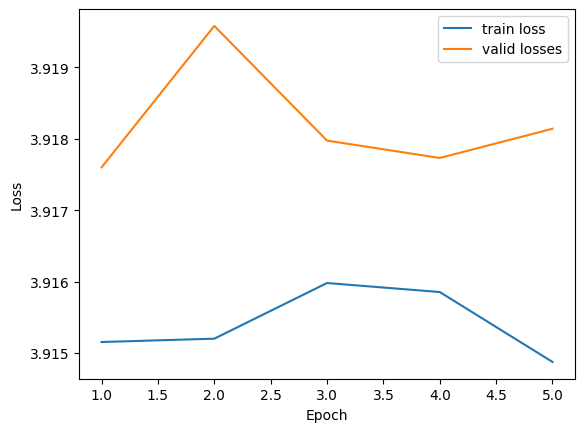

In [47]:
import matplotlib.pyplot as plt

x = range(1, num_epochs+1)
plt.plot(x, train_losses, label='train loss')
plt.plot(x, valid_losses, label='valid losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# test
test_loss, accuracy = one_epoch_test(data_loaders['test'], model, loss)


Testing: 100%|██████████████████████████████████| 40/40 [00:11<00:00,  3.53it/s]

Test Loss: 3.458607


Test Accuracy: 13% (166/1250)


In [ ]:
# log experiment
file_name = input("File name: ")

conn = sqlite3.connect('experiments.db')
cursor = conn.cursor()

sql = '''
INSERT INTO experiments (batch_size, num_epochs, dropout, learning_rate, optimizer,
weight_decay, scheduler, Accuracy, train_losses, valid_losses, model_file, scheduler_params)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
'''
train_losses_serial = json.dumps(train_losses).encode('utf-8')
valid_losses_serial = json.dumps(valid_losses).encode('utf-8')
scheduler_params = json.dumps(scheduler.state_dict())

values = (batch_size, num_epochs, dropout, learning_rate, opt, weight_decay, str(scheduler),
          accuracy.tolist(), train_losses_serial, valid_losses_serial, file_name, scheduler_params)

cursor.execute(sql, values)
conn.commit()

conn.close()